# KNIT7 OWL Demo Part 2 (Live Visualization with InfluxDB): Run OWL and Use InfluxDB

In the [preparation step](./knit7_owl_demo_prep2.ipynb), a Measurement Framework slice was created, and InfluxDB was installed in the Measurement Node. Now, we can perform packet captures using OWL and view the latency data live.


# Import Packages

In [ ]:
import os
import json
import traceback
import mflib 
print(f"MFLib version  {mflib.__version__} " )
from mflib.mflib import MFLib
import fabrictestbed_extensions
from fabrictestbed_extensions.fablib.fablib import fablib
from mflib import owl as owl

# Set Up Node Objects

Change `slice_name` to the appropriate value.

In [ ]:
%%time

slice_name = ""
mf = MFLib(slice_name)

meas_node_name = mf.measurement_node_name
node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'

try:
    slice = fablib.get_slice(name=slice_name)
except Exception as e:
    print(f"Fail: {e}")
print (slice)

try:
    meas_node = slice.get_node(name=meas_node_name)
    node1 = slice.get_node(name=node1_name)
    node2 = slice.get_node(name=node2_name)
    node3 = slice.get_node(name=node3_name)
except Exception as e:
    print(f"Fail: {e}")   
print (meas_node)

# Set Up InfluxDB Authentication

Clients (Experimental Nodes) that want to store data in the InfluxDB must have the authentication info. Below, we store the authentication info by querying them. The queried info is stored in a Python dictionary called `influxdb_connection`. You may need to wait a few seconds after the previous cell to run the cell below, to wait for InfluxDB to be fully set up. Check that all items in the `influxdb_connection` object are not empty, such as `influxdb_connection["influxdb_token"]`. If there are empty values, rerun this cell.

If you see get an error `name 'meas_node' is not defined`, re-run the cell "[Define Measurement Node](#set_meas_node)" and return here.

In [ ]:
print ("List InfluxDB auth info.")
influxdb_connection = {"influxdb_url":"", "influxdb_token":"", "influxdb_org":"",
                       "influxdb_bucket":"",  }

influxdb_ip = meas_node.get_ip_addrs()[2]["addr_info"][0]["local"]
influxdb_connection["influxdb_url"] = influxdb_ip 

command = f"sudo docker exec influxdb influx bucket list -o my-org  | grep 'my-bucket' | cut -f 1"
bucket_id, stderr= meas_node.execute(command)
bucket_id = bucket_id.strip()
print(f"Bucket id: {bucket_id}")
influxdb_connection["influxdb_bucket"] = bucket_id

command = f'''sudo docker exec influxdb influx auth list | grep "my-user's Token" | cut -f 3'''
token, stderr = meas_node.execute(command)
token = token.strip()
print(f"Token: {token}")
influxdb_connection["influxdb_token"] = token

influxdb_connection["influxdb_org"] = "my-org"

print("InfluxDB auth info:")
print(influxdb_connection)



## Pull OWL Docker Image to Experimental Nodes
As each node pulls the OWL image, you should see lines such as 
```
Node1
0.1.7: Pulling from fabrictestbed/owl
8b91b88d5577: Pulling fs layer
.
.
fbfb084c60a5: Pull complete
```
This step will take a few minutes. <a id='pull_owl'></a>

In [ ]:
# Pull the latest OWL image from Dockerhub
image_name="fabrictestbed/owl:0.1.7"
nodes = slice.get_nodes()

for node in nodes:
    print(node.get_name())
    node.execute(f"sudo docker pull {image_name}") 
    

## Run Packet Captures
### Start Sender and Capturer Containers Separately

Below, `Node2` and `Node3` will send packets to each other using containerized OWL; the Docker images were pulled and stored in each Experimental node. Each node will run the containers that send and capture packets. Here are the packet transfer flows in the steps below:
- Node1 -> Node2
- Node2 -> Node3
- Node3 -> Node1

In [ ]:
slice = fablib.get_slice(slice_name)

In [ ]:
owl.start_owl_sender(slice, src_node=slice.get_node(name='Node1'), dst_node=slice.get_node(name='Node2'), img_name=image_name, duration=900)

In [ ]:
owl.start_owl_capturer(slice,  dst_node=slice.get_node(name='Node1'), img_name=image_name, duration=900)

In [ ]:
owl.start_owl_sender(slice, src_node=slice.get_node(name='Node2'), dst_node=slice.get_node(name='Node3'), img_name=image_name, duration=900)

In [ ]:
owl.start_owl_capturer(slice,  dst_node=slice.get_node(name='Node3'), img_name=image_name, duration=900)

In [ ]:
owl.start_owl_sender(slice, src_node=slice.get_node(name='Node3'), dst_node=slice.get_node(name='Node1'), img_name=image_name, duration=900)

In [ ]:
owl.start_owl_capturer(slice,  dst_node=slice.get_node(name='Node3'), img_name=image_name, duration=900)

## Send PCAP Data From Experimental Node(s) to InfluxDB 

OWL stores packet capture data by storing `tcpdump` output to a file with the format: `<IP_address>.pcap`. 

`<IP_address>` is the address of the node that the capture file resides in.

Below, you need to specify value of `influxdb_sender_node_name` to one of the Experimental Node names. OWL will then send packet capture data from this node to the Measurement Node.

In the following cell, the authentication information for InfluxDB must have previously been set up. **Make sure you have run that [cell](#influx_auth) and return here.**

In [ ]:
influxdb_sender_node_name = "Node3"

pcap_file_name = owl.get_node_ip_addr(slice, influxdb_sender_node_name) + ".pcap"   # IP address of node from which to send to InfluxDB
print(f"Planning to send stored .pcap data from Node: {influxdb_sender_node_name}")
print(f"pcap Filename = {pcap_file_name}")
slice = fablib.get_slice(slice_name)
owl.send_to_influxdb(node=slice.get_node(name=influxdb_sender_node_name), 
                     pcapfile=pcap_file_name,
                     img_name=image_name,
                     influxdb_token=influxdb_connection["influxdb_token"],
                     influxdb_org=influxdb_connection["influxdb_org"], 
                     influxdb_url=influxdb_connection["influxdb_url"],
                     influxdb_bucket=influxdb_connection["influxdb_bucket"])


## Check Container Statuses

You should see a list of containers that are running from the previous step. Each node should have three containers named:
- `owl-capturer_<node_ip>`
- `owl-sender_<node_ip>`
- `owl-to-influx`


In [ ]:
slice = fablib.get_slice(slice_name)
owl.check_owl_all(slice)

## Stop all containers

This is helpful if you want to start over with the packet transfers.

In [ ]:
slice = fablib.get_slice(slice_name)
owl.stop_owl_all(slice)
owl.check_owl_all(slice)


# Viewing Data in InfluxDB

## Set Up SSH Tunnel
InfluxDB on the Measurement Node serves a webserver on port 8086 with the Node's IP address. To access the web GUI through your local computer's browser, you have to set up the necessary SSH keys and configuration to log in to the Measurement Node. After you've confirmed the login to the Measurement Node, the command to set up the tunnel requires defining the paths for the slice key, SSH config file, and Measurement Node IP address.

```
key=<fabric slice key>
ssh_conf=<fabric tunneling SSH configuration file>
ip=<measurement node's management IP address>
user=<OS username>
ssh -NL 9999:localhost:8086 -i $key -F $ssh_conf ${user}@${ip}
```

You can run the code below to get the SSH command to run (Set $key and $ssh_conf to the right values).

In [ ]:
import json
nodesdata = slice.list_nodes(output="json", quiet=True)
nodesdata = json.loads(nodesdata)
for n in nodesdata:
    if n["name"] == "meas-node":
        user = n["username"]
        ip = n["management_ip"]
        print(f"ssh -NL 9999:localhost:8086 -i $key -F $ssh_conf {user}@{ip}")

If successful, the terminal will display a detailed log of the SSH connection (befause the SSH command above used the "verbose/-v" flag). Look for messages like these near the bottom of the logs:
```
Authenticated to <Measurement Node IP address> (via proxy).
debug1: Local connections to LOCALHOST:9999 forwarded to remote address localhost:8086
debug1: Local forwarding listening on ::1 port 9999.
debug1: channel 0: new [port listener]
debug1: Local forwarding listening on 127.0.0.1 port 9999.
debug1: channel 1: new [port listener]
debug1: Requesting no-more-sessions@openssh.com
debug1: Entering interactive session.
```
**Keep the Terminal window that you used to run above open**. If you close it, the tunneling will stop. 
Test if the tunneling works by opening your local browser and entering this in the Address Bar:
```
localhost:9999
```


## Navigate InfluxDB on Local Browser

You will see a login page for the InfluxDB instance. Log in using `my-user` as username and `my-password` as the password:

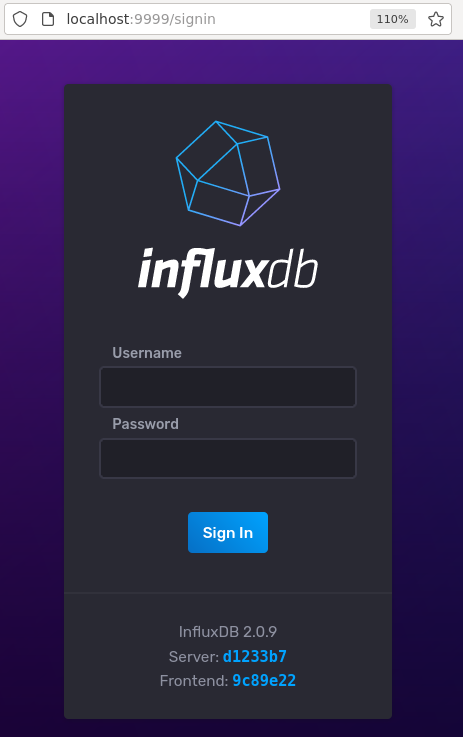

After logging in, go to the Explore section and in the filter boxes below, select "my-bucket", "owl", and "Latency"

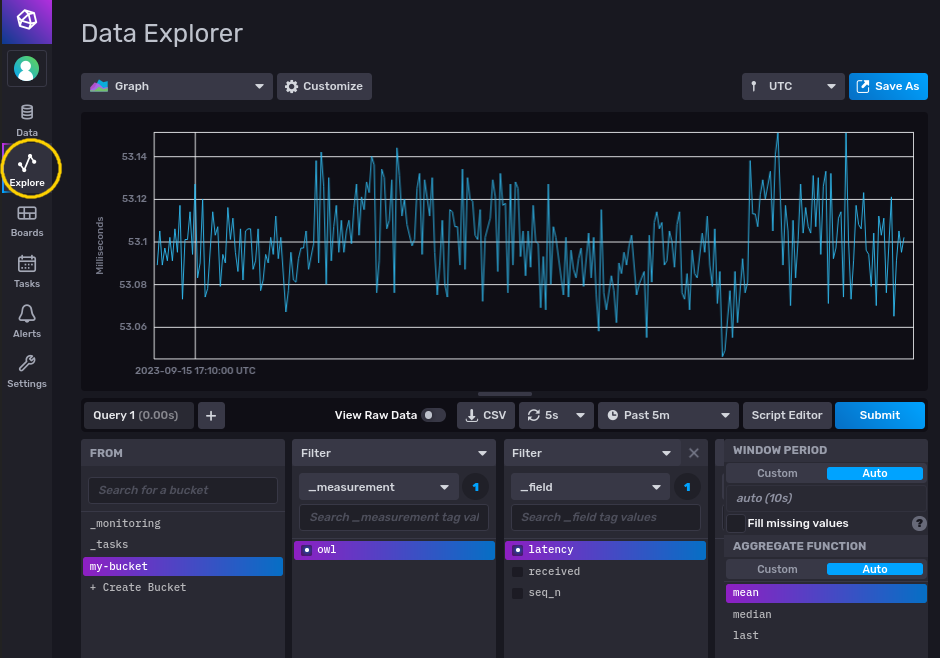

